In [65]:
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname('.'), '..')))

from PIL import Image, ImageOps, ImageEnhance 
import keras
from keras import backend as K
from keras.models import load_model
import matplotlib.patches as patches
from sklearn.preprocessing import Normalizer
import pickle
import math
from kerasutil import *
from yoloutil import *
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import random
from numpy import asarray

print('Keras version:',keras.__version__)
# confirm mtcnn was installed correctly
import mtcnn
from mtcnn.mtcnn import MTCNN
# print version
print(mtcnn.__version__)


Keras version: 2.2.4
0.0.9


In [66]:
def load_facenet_model():
    # load the model
    model_path = "/faceml/keras-facenet/model/facenet_keras.h5"
    model = load_model(model_path)
    model.load_weights('/faceml/keras-facenet/weights/facenet_keras_weights.h5')
    # summarize input and output shape
    print(model.inputs)
    print(model.outputs)
    return model

In [67]:
def load_image(filename):
    try:
        image = Image.open(filename)
        #image = resize_image(image,(160,160))
        # convert to RGB, if needed
        image = image.convert('RGB')
        # convert to array
        pixels = asarray(image)
        return pixels
    except:
        return None
    
def addMargin(startX,startY,endX,endY,margin):
    startX = int(startX - (startX*margin/100))
    endX = int(endX + (endX*margin/100))
    startY = int(startY - (startY*margin/100))
    endY = int(endY + (endY*margin/100))
    return startX,startY,endX,endY
            
def extract_face(detector, filename, margin):    
    x1,y1,x2,y2,faces, pixels = extract_all_faces(detector, filename, margin)
    if (faces is None or len(faces)==0):
        return (None,)*5,pixels
    return x1[0],y1[0],x2[0],y2[0],faces[0],pixels    
    
def extract_all_faces(detector, filename, margin, required_size=(160, 160)):
    print(filename)
    pixels = load_image(filename)
    if (pixels is None):
        return None,None,None,None,None,None
    return _extract_all_face(detector, pixels, margin, required_size)

def _extract_all_faces(detector, pixels, margin, required_size=(160, 160)):
    x1,y1,x2,y2 = list(),list(),list(),list()
    faces=list()
    # detect faces in the image
    results = detector.detect_faces(pixels)
   # extract the bounding box from the first face
    if (len(results) > 0):
        for i in range(len(results)):
            startX=results[i]['box'][0]
            startY=results[i]['box'][1]
            endX=startX + results[i]['box'][2]
            endY= startY + results[i]['box'][3]
            #x1[i], y1[i], width, height = results[i]['box']
            # bug fix
            startX,startY = abs(startX), abs(startY)
            # extract the face
            if margin > 0:
                startX,startY,endX,endY = addMargin(startX,startY,endX,endY,margin)

            face = pixels[startY:endY, startX:endX]
            (fH, fW) = face.shape[:2]
            #print(i,fH,fW)
            if fW < 10 or fH < 10:
                continue
            x1.append(startX)
            y1.append(startY)
            x2.append(endX)
            y2.append(endY)
            # resize pixels to the model size
            image = Image.fromarray(face)
            image = image.resize(required_size)
            face_array = asarray(image)
            faces.append(face_array)
        return x1, y1, x2, y2, faces, pixels
    else:
        return None,None,None,None,None,pixels

def resize_image(src_image, size=(128,128)): 
    
    # resize the image so the longest dimension matches our target size
    src_image.thumbnail(size, Image.ANTIALIAS)
    
    # Create a new square background image
    new_image = Image.new("RGB", size)
    
    # Paste the resized image into the center of the square background
    new_image.paste(src_image, (int((size[0] - src_image.size[0]) / 2), int((size[1] - src_image.size[1]) / 2)))
  
    # return the resized image
    return new_image

def resize_image_arr(src_image, size=(128,128)):
     image = Image.fromarray(src_image)
     return asarray(resize_image(image, size))


In [68]:
def show_objects(image, out_boxes, out_scores, out_classes, fig, columns, imgnum):
    
    # Set up some display formatting
    cmap = plt.get_cmap('tab20b')
    colors = [cmap(i) for i in np.linspace(0, 1, 20)]

    # Plot the image
    img = np.array(image)
    ax = fig.add_subplot(1, columns, imgnum)
    ax.imshow(img)

    # Set up padding for boxes
    img_size = model_image_size[0]
    pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
    pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
    unpad_h = img_size - pad_y
    unpad_w = img_size - pad_x

    # Use a random color for each class
    unique_labels = np.unique(out_classes)
    n_cls_preds = len(unique_labels)
    bbox_colors = random.sample(colors, n_cls_preds)

    # process each instance of each class that was found
    for i, c in reversed(list(enumerate(out_classes))):
        # Get the class name
        predicted_class = class_names[c]
        # Get the box coordinate and probability score for this instance
        box = out_boxes[i]
        score = out_scores[i]

        # Format the label to be added to the image for this instance
        label = '{} {:.2f}'.format(predicted_class, score)

        # Get the box coordinates
        top, left, bottom, right = box
        y1 = max(0, np.floor(top + 0.5).astype('int32'))
        x1 = max(0, np.floor(left + 0.5).astype('int32'))
        y2 = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
        x2 = min(image.size[0], np.floor(right + 0.5).astype('int32'))

        # Set the box dimensions
        box_h = ((y2 - y1) / unpad_h) * img.shape[0]
        box_w = ((x2 - x1) / unpad_w) * img.shape[1]
        y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
        x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]
        
        # Add a box with the color for this class
        color = bbox_colors[int(np.where(unique_labels == c)[0])]
        bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(bbox)
        plt.text(x1, y1, s=label, color='white', verticalalignment='top',
                bbox={'color': color, 'pad': 0})
        

In [69]:
# calculate a face embedding for each face in the dataset using facenet
from numpy import load
from numpy import expand_dims
from numpy import asarray
from numpy import savez_compressed
from keras.models import load_model

# get the face embedding for one face
def get_embedding(model, face_pixels):
    # scale pixel values
    face_pixels = face_pixels.astype('float32')
    # standardize pixel values across channels (global)
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    # transform face into one sample
    samples = expand_dims(face_pixels, axis=0)
    #print("samples:",samples.shape)
    # make prediction to get embedding
    yhat = model.predict(samples)
    #print("yhat:",yhat.shape, yhat[0])
    return yhat[0]

# load the facenet model
model = load_facenet_model()
print('Loaded Model')


/opt/conda/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


[<tf.Tensor 'input_1_4:0' shape=(?, 160, 160, 3) dtype=float32>]
[<tf.Tensor 'Bottleneck_BatchNorm_2/cond/Merge:0' shape=(?, 128) dtype=float32>]
Loaded Model


In [70]:
def show_image(im, x1, y1, x2, y2, fig=None, columns=1, imgnum=0):
    if fig is None:
        fig,ax = plt.subplots(1)
        plt.figure(figsize=(12,9))
    else:
        ax = fig.add_subplot(1,columns,imgnum)
    ax.imshow(im)
    if (x1 is None):
        return
    for i in range(len(x1)):
        rect = patches.Rectangle((x1[i],y1[i]),x2[i]-x1[i],y2[i]-y1[i],linewidth=1,edgecolor='r',facecolor='none', label=i)
        centerx = x1[i] + (x2[i]-x1[i])/2
        centery = y1[i] + (y2[i]-y1[i])/2
        ax.text(centerx, centery,str(i))
        # Add the patch to the Axes
        ax.add_patch(rect)
    if fig is None:
        plt.show()

In [71]:
def retryPred(x1,y1,x2,y2,pixels,model,in_encoder,recognizer, required_size=(160, 160)):
    maxProb=0
    max_yhat_class=[]
    max_yhat_prob=[]
    for margin in [0,1]:
        startX,startY,endX,endY = addMargin(x1,y1,x2,y2,margin)
        face = pixels[startY:endY,startX:endX]
        image = Image.fromarray(face)
        image = image.resize(required_size)
        face_array = asarray(image)
        embedding = get_embedding(model,face_array)
        samples = in_encoder.transform(embedding.reshape(1,-1))
        yhat_class = recognizer.predict(samples)
        yhat_prob = recognizer.predict_proba(samples)
        # get name
        class_index = yhat_class[0]
        class_probability = yhat_prob[0,class_index] * 100
        if class_probability > maxProb:
            max_yhat_prob=yhat_prob
            max_yhat_class=yhat_class
            maxProb = class_probability
    return max_yhat_class, max_yhat_prob

def processClassName(classname):
    classes=[]
    notclasses=[]
    if ("[" in classname):     
        for k in classname.split("]"):
            index=k.find("[")
            if index!=-1:
                tstr=k[index+1:]
                if ("not" in k):
                    notclasses.append(tstr)    
                else:
                    classes.append(tstr)

        expr=classname.replace("[","('")
        expr=expr.replace("]","' in objects)")
    else:
        classes=[classname]
        expr="('" + classname + "' in objects)"        
    return classes, notclasses, expr  

In [72]:
def detectobjects(image, class_names, boxes, scores, classes,yolo_model,input_image_shape):
    out_boxes, out_scores, out_classes = detect_objects(image, boxes, scores, classes,yolo_model,input_image_shape)
    objects=[class_names[out_classes[i]] for i in range(len(out_classes))]
    return objects, out_boxes, out_scores, out_classes    

In [73]:
def brightenImage(pixels, cnt):
    enhancer = ImageEnhance.Brightness(Image.fromarray(pixels))
    return asarray(enhancer.enhance(cnt))

def detectfaces(detector,out_encoder, recognizer, image_file, classexpr, confidence, objects=[], fig=None, columns=1, imgnum=0):
    pixels = load_image(image_file)
    _detectfaces(detector,out_encoder, recognizer, pixels, classexpr, confidence, objects, fig, columns, imgnum)

def _detectfaces(detector,out_encoder, recognizer, pixels, classexpr, confidence, objects=[], fig=None, columns=1, imgnum=0):
    x1, y1, x2, y2, faces, pixels = _extract_all_faces(detector, pixels,0)
    matched=False
    if not faces is None:
        show_image(pixels,x1, y1, x2, y2, fig, columns, imgnum)
        in_encoder = Normalizer(norm='l2')
        print("Faces:",len(faces))
        search_classes, not_classes, expr = processClassName(classexpr)
        for i in range(len(faces)):
            #print(i, (x2[i]-x1[i])*(y2[i]-y1[i]), faces[i].shape)
            yhat_class, yhat_prob = retryPred(x1[i],y1[i],x2[i],y2[i],pixels,model,in_encoder,recognizer)
            # get name
            class_index = yhat_class[0]
            class_probability = yhat_prob[0,class_index] * 100
            predict_names = out_encoder.inverse_transform(yhat_class)
            print(i, yhat_prob, predict_names, class_probability)
            if (class_probability >=confidence):
                objects.append(predict_names[0])
        print(objects)        
        matched=eval(expr)
        print(image_file,":",classexpr, ":Matched" if matched else ":Not Matched")
    else:
        print("No faces found")
    return matched    

In [74]:
recognizer_file = "/images/whatsapp/training/recognizer_keras.pickle"
labelencoder_file = "/images/whatsapp/training/labelencoder_keras.pickle"
recognizer = pickle.loads(open(recognizer_file, "rb").read())
out_encoder = pickle.loads(open(labelencoder_file, "rb").read())
detector = MTCNN()

class_names, anchors, yolo_model = open_yolo_model()
input_image_shape = K.placeholder(shape=(2, ))
boxes, scores, classes = yolo_eval(yolo_model.output, anchors, len(class_names), input_image_shape,
                                    score_threshold=0.3, iou_threshold=0.45)
model_image_size = (416, 416)

In [75]:
def scale_image(image, size):
    '''resize image with unchanged aspect ratio using padding'''
    iw, ih = image.size
    w, h = size
    scale = min(w/iw, h/ih)
    nw = int(iw*scale)
    nh = int(ih*scale)
    xpad, ypad=(w-nw)//2,(h-nh)//2
    image = image.resize((nw,nh), Image.BICUBIC)
    new_image = Image.new('RGB', size, (128,128,128))
    new_image.paste(image, (xpad, ypad))
    return new_image, scale, xpad, ypad

def getBoxArea(out_box):
    return (out_box[3]-out_box[1]) * (out_box[2]-out_box[0])

def getEnclosingArea(objects, classes, out_boxes, image_size, requiredSize):
    w,h=image_size
    image_area=w*h
    x1, y1, x2, y2 =w+1,h+1,0,0
    classcount=0
    for i in range(len(out_boxes)):
        area = getBoxArea(out_boxes[i])
        if (area/image_area)*100 > requiredSize:
            if (objects[i] in classes):
                classcount=classcount+1
                y1 = max(0, min(y1, out_boxes[i][0]))
                x1 = max(0, min(x1, out_boxes[i][1]))
                y2 = min(h, max(y2, out_boxes[i][2]))    
                x2 = min(w, max(x2, out_boxes[i][3]))
    return classcount, math.floor(x1), math.floor(y1), math.ceil(x2), math.ceil(y2)

def transpose(x1,y1,x2,y2,xpad,ypad,scale):
    newX1 = max(0,int((x1-xpad)/scale))
    newX2 = max(0,int((x2-xpad)/scale))
    newY1 = max(0,int((y1-ypad)/scale))
    newY2 = max(0,int((y2-ypad)/scale))
    return newX1, newY1, newX2, newY2

def detectfaces_scaled(image_file, query, confidence):
    orgimage = Image.open(image_file)
    return _detectfaces_scaled(orgimage, query, confidence)

def _detectfaces_scaled(orgimage, query, confidence):
    image, scale, xpad, ypad= scale_image(orgimage, tuple(reversed(model_image_size)))
    objects=[]
    objects, out_boxes, out_scores, out_classes = detectobjects(image, class_names, boxes, scores,classes,yolo_model,input_image_shape)
    fig=plt.figure(figsize=(16,9))
    show_objects(image, out_boxes, out_scores, out_classes, fig, 3, 1)
    classcount, x1, y1, x2, y2 = getEnclosingArea(objects, "person", out_boxes, image.size, 0.5)
    if (x1 < image.size[0]):
        #map coordinates onto original image
        newX1, newY1, newX2, newY2 = transpose(x1,y1,x2,y2,xpad,ypad,scale)
        print(newX1, newY1, newX2, newY2)
        show_image(orgimage, [newX1], [newY1], [newX2], [newY2], fig,3, 2)
        personimage = asarray(orgimage)[newY1:newY2, newX1:newX2]
        ih, iw = personimage.shape[0], personimage.shape[1]

        minwidth = classcount*300 #min 300px per person
        zoom=1
        if (iw < min(600,minwidth)): #need min 600 width image. if image was smaller, scaling up more will cause more blur
            zoom = min(600,minwidth)/iw
            iw = int(iw*zoom)
            ih = int(ih*zoom)
        if (zoom!=1):    
            personimage, scale, xpad, ypad=scale_image(Image.fromarray(personimage), (iw, ih))

        pImage=Image.fromarray(asarray(personimage))
        matched=False
        oldobjects=objects.copy()
        for deg in [0,90,-90,180]:
            objects=oldobjects.copy()
            imgtouse=pImage
            if deg!=0:
                print("trying with rotation:", deg)
                imgtouse=pImage.rotate(deg)
            matched=_detectfaces(detector, out_encoder, recognizer, asarray(imgtouse), query, confidence, objects, fig,3, 3)
            if matched:
                break
    plt.show()

Faces: 3
0 [[ 0.00313679  0.99508103  0.00178218]] ['samir'] 99.5081026759
1 [[ 0.96945426  0.0247556   0.00579013]] ['atharva'] 96.9454264447
2 [[ 0.00378969  0.00534086  0.99086945]] ['sangeeta'] 99.0869449842
['samir', 'atharva', 'sangeeta']
/faceml/sampleimages/image1.jpg : [samir] :Matched


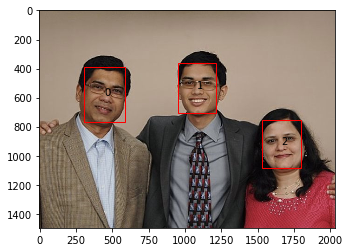

<Figure size 864x648 with 0 Axes>

In [76]:
image_file='/faceml/sampleimages/image1.jpg'
objects=[]
detectfaces(detector, out_encoder, recognizer, image_file, "[samir]", 80)

Faces: 3
0 [[ 0.00313679  0.99508103  0.00178218]] ['samir'] 99.5081026759
1 [[ 0.96945426  0.0247556   0.00579013]] ['atharva'] 96.9454264447
2 [[ 0.00378969  0.00534086  0.99086945]] ['sangeeta'] 99.0869449842
['samir', 'atharva', 'sangeeta']
/faceml/sampleimages/image1.jpg : [samir] and [sangeeta] and [atharva] :Matched


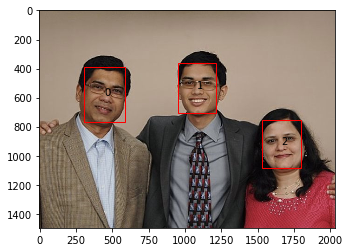

<Figure size 864x648 with 0 Axes>

In [77]:
image_file='/faceml/sampleimages/image1.jpg'
objects=[]
detectfaces(detector, out_encoder, recognizer, image_file, "[samir] and [sangeeta] and [atharva]", 80, objects)

Faces: 3
0 [[ 0.00313679  0.99508103  0.00178218]] ['samir'] 99.5081026759
1 [[ 0.96945426  0.0247556   0.00579013]] ['atharva'] 96.9454264447
2 [[ 0.00378969  0.00534086  0.99086945]] ['sangeeta'] 99.0869449842
['samir', 'atharva', 'sangeeta']
/faceml/sampleimages/image1.jpg : [samir] and [sangeeta] and not [atharva] :Not Matched


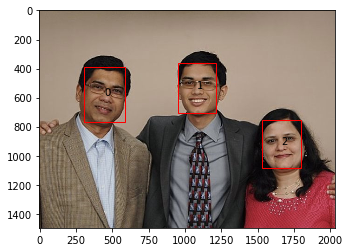

<Figure size 864x648 with 0 Axes>

In [78]:
image_file='/faceml/sampleimages/image1.jpg'
objects=[]
detectfaces(detector, out_encoder, recognizer, image_file, "[samir] and [sangeeta] and not [atharva]", 80, objects)

Faces: 2
0 [[ 0.14984891  0.27914296  0.57100813]] ['sangeeta'] 57.1008129271
1 [[ 0.10015129  0.18858445  0.71126426]] ['sangeeta'] 71.1264257927
[]
/faceml/sampleimages/newyork.jpg : [samir] or [sangeeta] or [atharva] :Not Matched


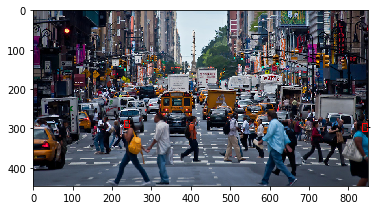

<Figure size 864x648 with 0 Axes>

In [79]:
image_file='/faceml/sampleimages/newyork.jpg'
objects=[]
detectfaces(detector, out_encoder, recognizer, image_file, "[samir] or [sangeeta] or [atharva]", 80, objects)

Faces: 2
0 [[ 0.1370515  0.146731   0.7162175]] ['sangeeta'] 71.6217500376
1 [[ 0.06332148  0.89065673  0.04602179]] ['samir'] 89.065673383
['samir']
/faceml/sampleimages/lucerne.jpg : [samir] and [sangeeta] :Not Matched


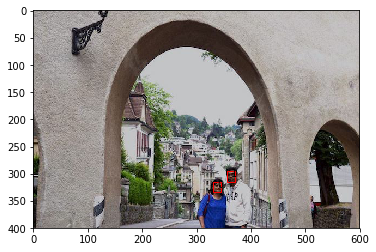

<Figure size 864x648 with 0 Axes>

In [80]:
objects=[]
image_file='/faceml/sampleimages/lucerne.jpg'
detectfaces(detector, out_encoder, recognizer, image_file, "[samir] and [sangeeta]", 80, objects)

298 284 402 400
Faces: 2
0 [[ 0.03958396  0.03528753  0.92512851]] ['sangeeta'] 92.5128514999
1 [[ 0.04765363  0.9305604   0.02178598]] ['samir'] 93.0560396928
['person', 'person', 'person', 'sangeeta', 'samir']
/faceml/sampleimages/lucerne.jpg : [samir] and [sangeeta] :Matched


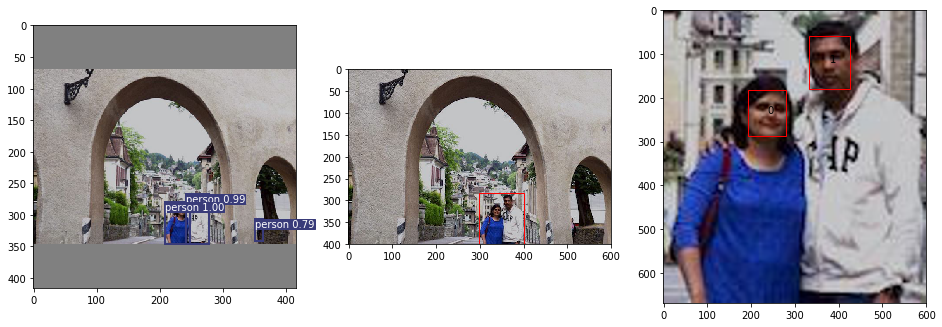

In [81]:
image_file='/faceml/sampleimages/lucerne.jpg'
detectfaces_scaled(image_file, "[samir] and [sangeeta]",80)

968 321 1337 595
Faces: 1
0 [[ 0.94913921  0.04392528  0.00693551]] ['atharva'] 94.9139207778
['person', 'person', 'person', 'person', 'person', 'car', 'atharva']
/faceml/sampleimages/atharva0.jpg : [atharva] :Matched


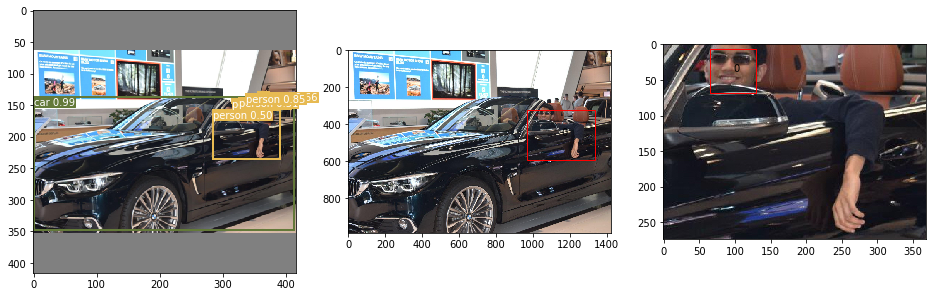

In [82]:
#match for person name(face recognition) and object type(object detection), by zooming in if needed
image_file='/faceml/sampleimages/atharva0.jpg'
detectfaces_scaled(image_file,"[atharva]",80)

317 510 767 727
No faces found
trying with rotation: 90
No faces found
trying with rotation: -90
Faces: 1
0 [[ 0.98618844  0.00929304  0.00451852]] ['atharva'] 98.6188440448
['person', 'atharva']
/faceml/sampleimages/atharva1.jpg : [atharva] :Matched


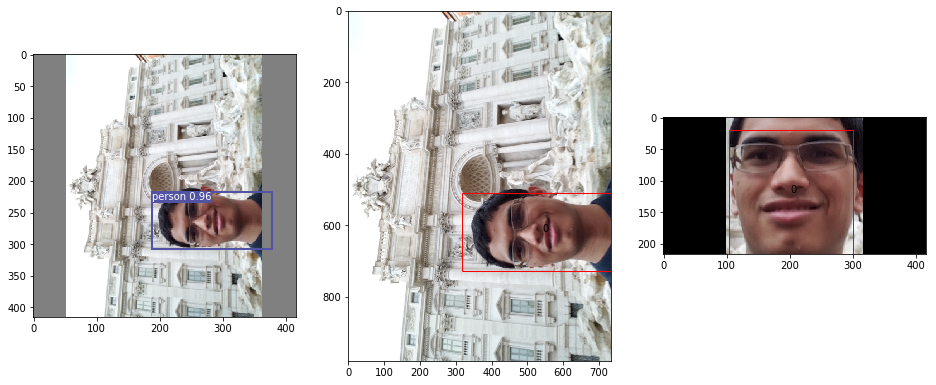

In [83]:
image_file='/faceml/sampleimages/atharva1.jpg'
detectfaces_scaled(image_file,"[atharva]",80)